In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

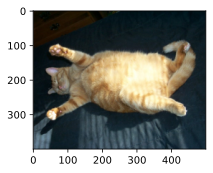

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

In [3]:
def apply(image, aug, num_rows=2, num_cols=4, scale=1.5):
    process_image = [aug(image) for _ in range(num_rows * num_cols)]
    d2l.show_images(process_image, num_rows, num_cols, scale=scale)

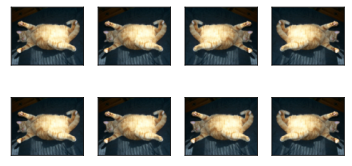

In [4]:
 apply(img, torchvision.transforms.RandomHorizontalFlip())

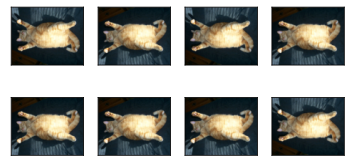

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

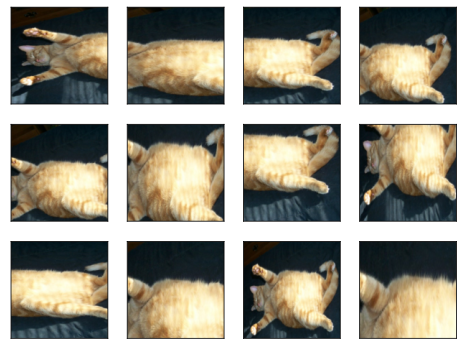

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)
)
apply(img, shape_aug, num_rows=3, num_cols=4, scale=2)

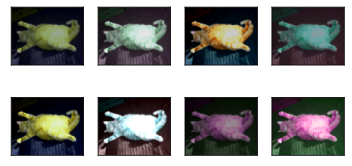

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
))
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)

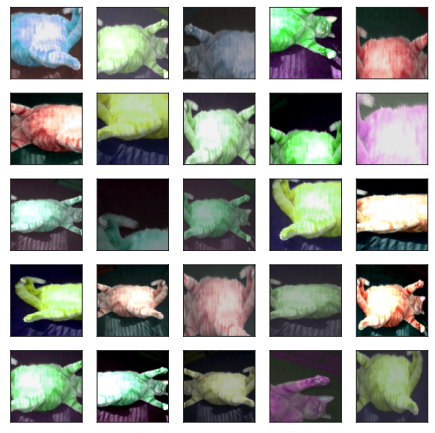

In [8]:
aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomHorizontalFlip(),
    shape_aug,
    color_aug
])
apply(img, aug, num_rows=5, num_cols=5, scale=1.5)

In [ ]:
all_images = torchvision.datasets.CIFAR10(
    train=True,
    root='../data',
    download=True
)

 61%|██████    | 103579648/170498071 [03:20<02:27, 455181.98it/s] 

In [ ]:
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [ ]:
len(all_images), all_images[0], all_images[0][0], type(all_images[0][0]), all_images[0][0].size

In [ ]:
# 获取第一张图片的形状
img_shape = all_images[0][0].size
print("Image shape:", img_shape)

In [ ]:
train_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [ ]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root='../data', train=is_train,
        transform=augs, download=True
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size,
        shuffle=is_train,
        num_workers=16
    )
    return dataloader

In [ ]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [ ]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [ ]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_normal_(m.weight)
        '''
        在 PyTorch 中，xavier_normal_ 和 xavier_normal 这两个函数的区别在于它们是 in-place 操作还是返回一个新的张量。具体来说：
            - xavier_normal_ 是一个 in-place 操作，会将输入张量中的值替换为按 Xavier 初始化方法随机生成的值，并返回原始张量。
            - xavier_normal 不是 in-place 操作，会返回一个新的张量，该张量包含按 Xavier 初始化方法随机生成的值。
        因此，如果想要直接修改原始张量，可以使用 xavier_normal_；如果想要保留原始张量并返回新的张量，则可以使用 xavier_normal。

        在 PyTorch 中，默认情况下，建议使用 xavier_normal 函数而不是 xavier_normal_ 函数。原因是，xavier_normal_ 是一个 in-place 操作，会修改原始张量，如果不小心操作错误可能会导致不可逆的损失。而 xavier_normal 返回一个新的张量，更加安全可靠。但具体使用哪个函数还需要根据实际情况来决定，比如在内存受限的情况下，可以使用 xavier_normal_ 来减少内存占用。
        '''
    net.apply(init_weights)


In [ ]:
def train_with_data_aug(train_aug, test_aug, net, lr=0.001):
    train_iter = load_cifar10(True, train_aug, batch_size)
    test_iter = load_cifar10(False, test_aug, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

In [ ]:
# train_with_data_aug(train_aug, test_aug, net)

In [ ]:
import time
start = time.time()
# train_with_data_aug(test_aug, test_aug, net)
end = time.time()
print('Time Cost: ', end - start)